In [1]:
import ipywidgets as widgets

path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='File path:',
    disabled=False
)


tiff_path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='tiff stack:',
    disabled=False
)

display(path)
display(tiff_path)


Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='File path:', placeho…

Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='tiff stack:', placeh…

In [34]:
%matplotlib inline
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
from scipy.optimize import minimize
from scipy.spatial import distance
import ipyvolume as ipv
import numpy as np
from skimage import io, filters
import matplotlib.pyplot as plt
import matplotlib.tri as tri

reader = vtk.vtkSTLReader()
reader.SetFileName(path.value)
reader.Update()

tiff_reader = vtk.vtkTIFFReader()
tiff_reader.SetFileName(tiff_path.value)
tiff_reader.Update()

In [35]:
vtkImage = tiff_reader.GetOutput()
dim = vtkImage.GetDimensions()
wrap = dsa.WrapDataObject(vtkImage)

stack = wrap.PointData['Tiff Scalars'].reshape(dim,order='F')


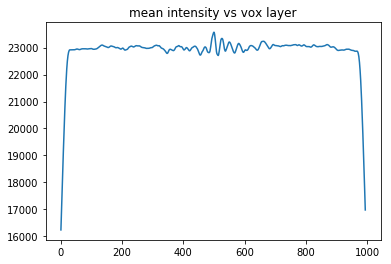

In [36]:
mean_z_intensity = np.mean(stack, axis = (0,1))

fig, ax = plt.subplots()
ax.set_title('mean intensity vs vox layer')
ax.plot(range(mean_z_intensity.shape[0]), mean_z_intensity)
plt.show()

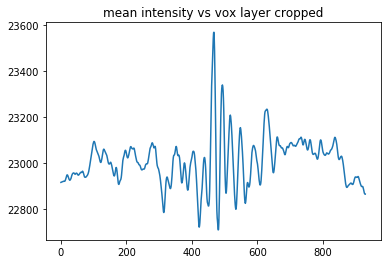

In [37]:
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr

cpt = importr('changepoint')

cpm_result = cpt.multiple_mean_norm(FloatVector(mean_z_intensity),"BinSeg","MBIC",0,2,True,True,1)

change_pts = cpt.cpts(cpm_result)

bot = int(change_pts[0])+ 20
top = int(change_pts[1])- 20
cut_warp = mean_z_intensity[bot:top]

fig, ax = plt.subplots()
ax.set_title('mean intensity vs vox layer cropped')
ax.plot(range(cut_warp.shape[0]), cut_warp)
plt.show()

In [38]:
bd = vtkImage.GetExtent()
voi = [bd[0],bd[1],bd[2],bd[3],bot,top]
crop_image = vtk.vtkExtractVOI()
crop_image.SetVOI(voi)
crop_image.SetInputConnection(tiff_reader.GetOutputPort())
crop_image.SetSampleRate(1,1,1)
crop_image.Update()

In [39]:
mesh = dsa.WrapDataObject(reader.GetOutput())
pt_cloud = mesh.GetPoints()

In [40]:
z_l = np.min(pt_cloud[:,2])
z_u = np.max(pt_cloud[:,2])
center = mesh.GetCenter()
z = z_u - z_l +2 

pt_cloud = pt_cloud[np.logical_and((z_l + 20*2e-3)< pt_cloud[:,2],pt_cloud[:,2] < (z_u - 20*2e-3))]

In [41]:

def opt_cyl(c,z,z_l,X,r):
    ray = np.array([[c[0]-c[2],c[1]-c[3],z]])
    X_v = X - np.array([c[2],c[3],z_l])
    dist_ar = distance.cdist(ray,X)
    diff = np.abs(dist_ar-r)
    return np.mean(diff)

x_0 = np.array([center[0],center[1],center[0],center[1]])
bd = ((mesh.GetBounds()[0:2]),(mesh.GetBounds()[2:4]),(mesh.GetBounds()[0:2]),(mesh.GetBounds()[2:4]))
result = minimize(opt_cyl,x_0,args=(z,z_l,pt_cloud,5.8/2),bounds = bd)


In [42]:
from numpy import linalg as la

top_v = np.array([result.x[0],result.x[1],z_u])
rotation_ori = np.array([result.x[2],result.x[3],z_l])

ray = top_v-rotation_ori
vert = np.array([center[0],center[1],1])

angle = np.arccos(np.vdot(ray,vert)/(la.norm(ray)*la.norm(vert)))
rotate = vtk.vtkTransform()
rotate.RotateWXYZ(np.rad2deg(angle),rotation_ori)

transform_filter = vtk.vtkTransformPolyDataFilter()
transform_filter.SetInputConnection(reader.GetOutputPort())
transform_filter.SetTransform(rotate)
transform_filter.Update()

rotated_mesh = dsa.WrapDataObject(transform_filter.GetOutput())

cyl_to_cartesian = vtk.vtkCylindricalTransform()
cartesian_to_cyl = cyl_to_cartesian.GetInverse()

coord_transform = vtk.vtkTransformPolyDataFilter()
coord_transform.SetTransform(cartesian_to_cyl)
coord_transform.SetInputConnection(transform_filter.GetOutputPort())
coord_transform.Update()

In [43]:
resampler = vtk.vtkImageReslice()
resampler.SetResliceTransform(rotate)
resampler.SetInputConnection(crop_image.GetOutputPort())
resampler.Update()

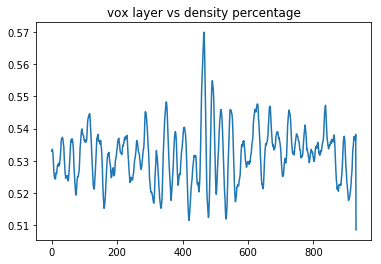

In [44]:
import numpy.ma as ma
from skimage.filters import threshold_otsu

def filter(im):
    wrap = dsa.WrapDataObject(im)
    dim = im.GetDimensions()
    np_ar = wrap.PointData['Tiff Scalars'].reshape(dim,order='F')
    
    masked = ma.masked_where(np_ar == 0, np_ar)
    thresh = threshold_otsu(masked.compressed())
    
    thres_fil = vtk.vtkImageThreshold()
    thres_fil.ThresholdByLower(thresh)
    thres_fil.ReplaceInOn()
    thres_fil.SetInValue(0)
    thres_fil.SetOutValue(1)
    thres_fil.SetInputData(im)
    thres_fil.Update()
    
    n_wrap = dsa.WrapDataObject(thres_fil.GetOutput())
    n_np_ar = n_wrap.PointData['Tiff Scalars'].reshape(dim,order='F')
    
    n_masked = ma.masked_where(np_ar==0,n_np_ar)
    
    return n_masked

dim = resampler.GetOutput().GetDimensions()
vtk_cropped_rs_w = dsa.WrapDataObject(resampler.GetOutput())
cropped_rs = vtk_cropped_rs_w.PointData['Tiff Scalars'].reshape(dim,order='F')

filtered_img = filter(resampler.GetOutput())

z_mean = np.mean(filtered_img,axis=(0,1))
fig, ax = plt.subplots()
ax.set_title('vox layer vs density percentage')
ax.plot(z_mean)
plt.show()

In [45]:
mesh_cyl = dsa.WrapDataObject(coord_transform.GetOutput())
pt_cloud_cyl = mesh_cyl.GetPoints()

In [68]:
np.save('./data/pt_cloud_cyl',pt_cloud_cyl)

Initial number of peaks:  250973
Peaks after trimming saddle points:  70320
Peaks after trimming nearby peaks:  70320


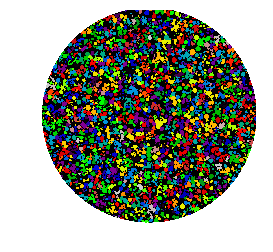

In [20]:
import porespy as ps
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
import scipy.ndimage as spim
from skimage.morphology import watershed
from porespy.tools import randomize_colors
import scipy as sp

sigma = 0.4
dt = spim.distance_transform_edt(input=filtered_img)
dt = spim.gaussian_filter(input=dt, sigma=sigma)
peaks = find_peaks(dt=dt)

print('Initial number of peaks: ', spim.label(peaks)[1])
peaks = trim_saddle_points(peaks=peaks, dt=dt, max_iters=500)
print('Peaks after trimming saddle points: ', spim.label(peaks)[1])
peaks = trim_nearby_peaks(peaks=peaks, dt=dt)
peaks, N = spim.label(peaks)
print('Peaks after trimming nearby peaks: ', N)

regions = watershed(image=-dt, markers=peaks, mask=dt > 0)
regions = randomize_colors(regions)

plt.imshow((regions*filtered_img)[:, :, 100], cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.show()


In [22]:
import openpnm as op

net = ps.networks.regions_to_network(im=regions*filtered_img, dt=dt, voxel_size=2e-3)

pn = op.network.GenericNetwork()
pn.update(net)
prj = pn.project

____________________________________________________________
Extracting pore and throat information from image


100%|████████████████████████████████████████████████████████████████████████████| 70320/70320 [19:29<00:00, 60.14it/s]


In [23]:
prj.export_data(filename='./data/extracted_network', filetype='vtk')

In [26]:
im = ps.tools.align_image_with_openpnm(filtered_img).astype(int)
ps.io.to_vtk(im, path='./data/extracted_network')